In [78]:
import os
import json
import cv2
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
import torch
from torch.utils.data import Dataset

%load_ext autoreload
%autoreload 2

data_path = '/datasets/TACO-master/data'
anno_file = 'annotations.json'
anno_u_file = 'annotations_unofficial.json'

with open(os.path.join(data_path, anno_file), 'r') as f:
    anno = json.load(f)
with open(os.path.join(data_path, anno_u_file), 'r') as f:
    annou = json.load(f)
    
len(anno)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


7

In [79]:
!ls /datasets/TACO-master/data

all_image_urls.csv	     batch_1   batch_12  batch_15  batch_4  batch_7
annotations.json	     batch_10  batch_13  batch_2   batch_5  batch_8
annotations_unofficial.json  batch_11  batch_14  batch_3   batch_6  batch_9


In [80]:
list(anno.keys())

['info',
 'images',
 'annotations',
 'scene_annotations',
 'licenses',
 'categories',
 'scene_categories']

## Data Structure
After taking a look at the data folder, as well as on the official website, it seems the data is structured as follows:  
- Actual images are stored in folders ```batch_1``` ... ```batch_15```  
- Information of images are stored in ```anotations.json```. The important infos are:  
    - *images*: Contains img_id, and file_path, used to retrieve the image  
    - *annotations*: Contains category_id for classification, segmentation data (polygon) and bboxes. Each entry is for 1 object annotation (so 1 image can have multiple entries). img_id is used as key to connect to the actual images

In [81]:
len(anno['annotations'])

4784

In [82]:
dataDir= '/datasets/TACO-master/data'
dataType='val2017'
annFile='{}/annotations.json'.format(dataDir)
coco=COCO(annFile)


loading annotations into memory...
Done (t=0.32s)
creating index...
index created!


In [83]:
annotation_ids = coco.getAnnIds(imgIds=2)
#coco.loadAnns(annotation_ids)

# Custom Dataset Class  
- Because of the rather complex structure of the data folder, we need to create a Dataset class that inherit

In [95]:
from pycocotools import mask as mask_utils


class CustomDataset:
    def __init__(self, annotation_file, image_root):
        self.coco = COCO(os.path.join(image_root, annotation_file))
        self.image_root = image_root
        self.image_ids = list(self.coco.imgs.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        # retrieve image info
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.image_root, image_info['file_name'])
        
        # load image
        image = cv2.imread(image_path)  

        # load annotations for current image
        annotation_ids = self.coco.getAnnIds(imgIds=image_id) # id
        annotations = self.coco.loadAnns(annotation_ids)

     # Extract bounding boxes, class labels, and segmentation masks
        boxes = [self._annotation_to_bbox(anno) for anno in annotations]
        labels = [anno['category_id'] for anno in annotations]
        masks = [anno['segmentation'] for anno in annotations]
        
        # append labels to end of bboxes (for Albumentation)
        bbox_extend = [box + [label] for box, label in zip(boxes, labels)]
        
        # Convert segmentation masks to binary masks
        binary_masks = []
        for mask in masks:
            binary_mask = self.decode_mask(mask, image_info)
            binary_masks.append(binary_mask)
            

        # Convert segmentation masks to binary masks
        mask_array = []
        for mask in masks:
            binary_mask = self.decode_mask(mask, image_info)
            mask_array.append(binary_mask)
        
        # Convert binary masks to a single mask tensor
        # mask_tensor = torch.stack([torch.from_numpy(mask.astype(float)) for mask in binary_masks])
        mask_tensor = torch.stack([self._convert_binary_mask(mask) for mask in mask_array])

        return image, boxes, bbox_extend, labels, mask_array, mask_tensor
        # return image, boxes, labels, mask_tensor
    
    
    def decode_mask(self, mask, image_info):
        if type(mask) == list:
            # If the mask is a list, use the COCO API to decode it
            rle = mask_utils.frPyObjects(mask, image_info['height'], image_info['width'])
            binary_mask = mask_utils.decode(rle)
        else:
            # If the mask is already a single binary mask, return it as is
            binary_mask = mask

        return binary_mask

    def _annotation_to_bbox(self, annotation):
        # Convert annotation to bounding box [x1, y1, x2, y2] format
        bbox = annotation['bbox']
        x1 = bbox[0]
        y1 = bbox[1]
        x2 = x1 + bbox[2]
        y2 = y1 + bbox[3]
        
        return [x1, y1, x2, y2]
    
    def _convert_binary_mask(self, mask):
        # Convert binary mask to tensor
        if len(mask.shape) == 2:
            # Add a channel dimension for grayscale masks
            mask = mask[:, :, None]
        elif len(mask.shape) == 3 and mask.shape[2] > 1:
            # Convert RGB masks to grayscale
            mask = mask.mean(axis=2, keepdims=True)
        return torch.from_numpy(mask.astype(float))
    

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


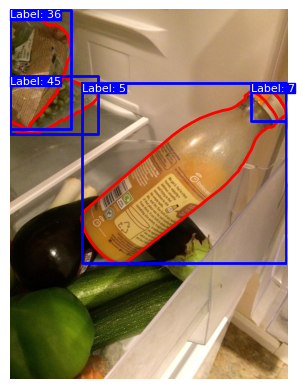

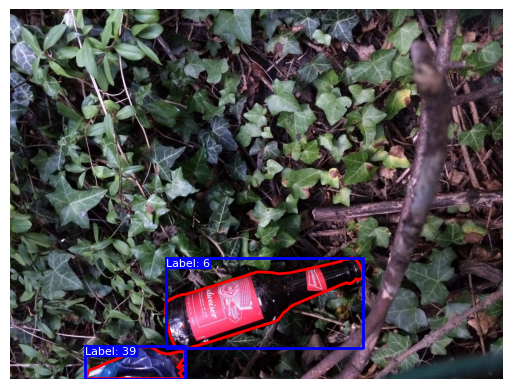

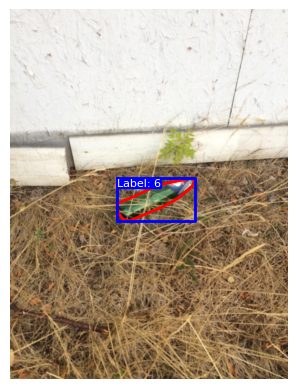

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np


annotation_file = 'annotations.json'
image_root = '/datasets/TACO-master/data'

# Instantiate the CustomDataset class
dataset = CustomDataset(annotation_file, image_root)

# Choose a subset of images to visualize
indices = [13, 26, 39]  # Specify the indices of the images you want to visualize

# Visualize the images, segmentations, and bounding boxes
for idx in indices:
    image, boxes, labels, masks = dataset[idx]

    # Plot the image
    plt.figure()
    plt.imshow(image[:, :, ::-1])  # Convert BGR to RGB for visualization

    # Plot the segmentations
    for mask in masks:
        seg_mask = np.array(mask[0], dtype=np.int32)
        polygon = Polygon(seg_mask.reshape((int(len(seg_mask) / 2), 2)), closed=True, fill=None, edgecolor='red', linewidth=2)
        plt.gca().add_patch(polygon)

    # Plot the bounding boxes
    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box
        plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color='blue', linewidth=2)
        plt.text(x1, y1, f"Label: {label}", color='white', fontsize=8, verticalalignment='top',
                 bbox={'color': 'blue', 'pad': 0})

    plt.axis('off')
    plt.show()

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


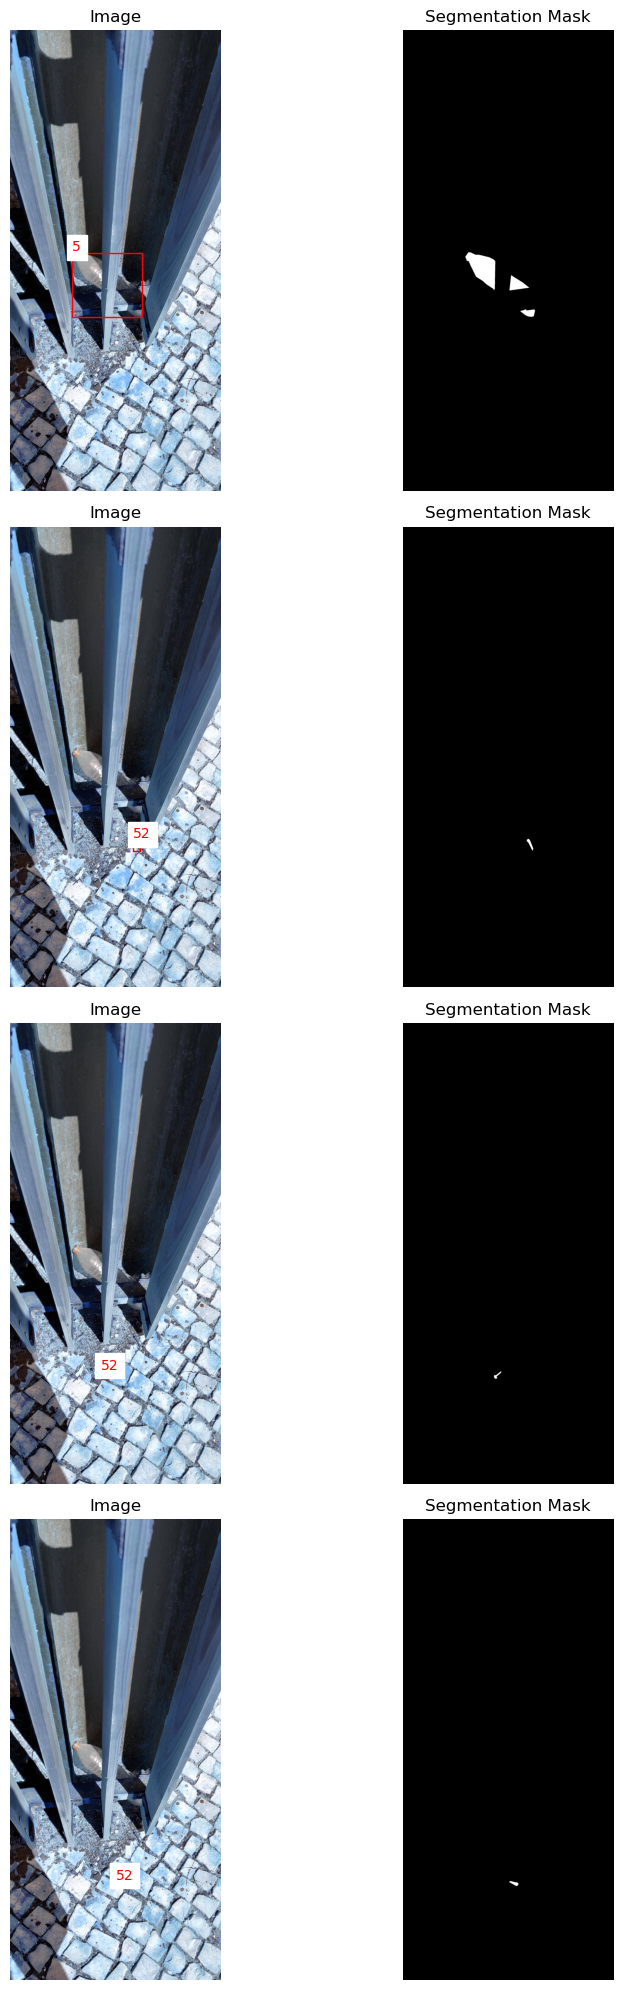

In [96]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_sample(image, boxes, labels, binary_masks):
    num_objects = len(boxes)

    fig, axes = plt.subplots(num_objects, 2, figsize=(10, 5 * num_objects))
    if num_objects > 1:
        axes = axes.flatten()

    for idx, (box, label, binary_mask) in enumerate(zip(boxes, labels, binary_masks)):
        # Display image with bounding boxes
        axes[idx * 2].imshow(image)
        axes[idx * 2].set_title('Image')
        axes[idx * 2].axis('off')
        axes[idx * 2].add_patch(
            plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color='r')
        )
        axes[idx * 2].text(box[0], box[1] - 10, label, color='r', backgroundcolor='w')

        # Display binary mask
        axes[idx * 2 + 1].imshow(binary_mask, cmap='gray')
        axes[idx * 2 + 1].set_title('Segmentation Mask')
        axes[idx * 2 + 1].axis('off')

    plt.tight_layout()
    plt.show()

    
annotation_file = 'annotations.json'
image_root = '/datasets/TACO-master/data'

# Instantiate the CustomDataset class
dataset = CustomDataset(annotation_file, image_root)

def viz_idx(idx):
    sample_image, sample_boxes, _, sample_labels, _,  sample_binary_masks = dataset[idx]
    visualize_sample(sample_image, sample_boxes, sample_labels, sample_binary_masks)
    
viz_idx(130)

In [148]:
import albumentations as A
import cv2

transform = A.Compose([
    A.Resize(1024, 1024),
    # A.RandomCrop(width=512, height=512), # this affects the data too much, as many bboxes get removed completely
    A.HorizontalFlip(p=0.6),
    A.RandomBrightnessContrast(p=0.3),
], bbox_params=A.BboxParams(format='pascal_voc'))

In [147]:
import matplotlib.patches as patches
    
def plot_image_with_bboxes(image, bboxes):
    """
    Plot an image with bounding boxes and labels.

    Args:
        image (numpy.ndarray): Input image as a NumPy array.
        bboxes (list): List of bounding boxes appended with the label, in the format [x1, y1, x2, y2, label].
    """
    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Iterate over bounding boxes and labels
    for bbox in bboxes:
        x1, y1, x2, y2, label = bbox[:5]

        # Calculate the width and height of the bounding box
        width = x2 - x1
        height = y2 - y1

        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the axes
        ax.add_patch(rect)

        # Add label text on top of the bounding box
        ax.text(x1, y1, str(label), color='r', verticalalignment='top',
                bbox={'color': 'white', 'alpha': 0.7, 'pad': 2})

    # Set axis limits to match image dimensions
    ax.set_xlim(0, image.shape[1])
    ax.set_ylim(image.shape[0], 0)

    # Remove the axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Show the plot
    plt.show()

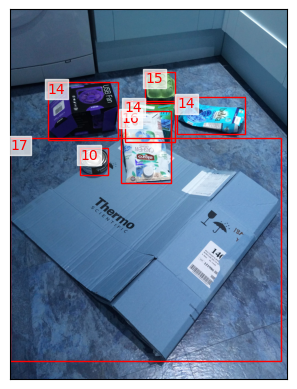

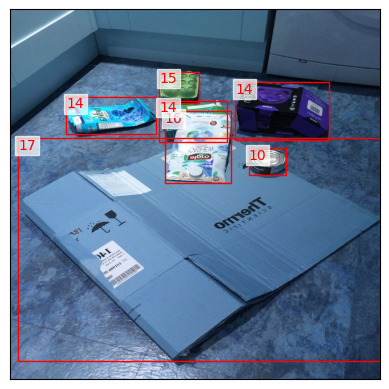

In [149]:
def test_augment(idx):
    img, _, bbox, labels, masks, _ = dataset[idx]
    plot_image_with_bboxes(img, bbox)
    
    transformed = transform(image=img, bboxes=bbox)
    transformed_image = transformed['image']
    transformed_bboxes = transformed['bboxes']
    
    
    plot_image_with_bboxes(transformed_image, transformed_bboxes)

test_augment(100)